# Evaluate Classification with Decision Tree

## Content
1. [Import Data](#import)
2. [Create / Train Model](#create-train)
3. [Metrics / Confusion Matrix](#metrics)
4. [Grid Search](#grid)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

<a id="import"></a>
## Import Data

In [34]:
df = pd.read_csv('files/fo_smote.csv')
not_automatable = [item[0] for item in pd.read_csv("files/not_automatable.csv").values.tolist()]

# calculate fo_computerisation based on 'df_probability'
df['fo_computerisation'] = df['fo_probability'].apply(lambda x: 1 if x >= 0.5 else 0)

df.head(2)

,isco08,Berufshauptgruppe,s1,s2,s3,s4,s5,s6,s7,s8,...,a45,a46,a47,a48,a49,a50,a51,a52,fo_probability,fo_computerisation
0,2655,2,0.72,0.72,0.69,0.69,0.50,0.50,0.50,0.47,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.37,0
1,2612,2,0.81,0.75,0.81,0.72,0.81,0.66,0.56,0.72,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40,0


<a id="create-train"></a>
## Split in Train / Test Set and train Model

In [35]:
# Declare x, y & split Data in training and test (80/20)
X = df[not_automatable]
y = df['fo_computerisation']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the model
model = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 2, min_samples_split = 10)
model.fit(X_train_scaled, y_train)

# You can now use model.predict to make predictions on unseen data
predictions = model.predict(X_test_scaled)

In [37]:
# Make prediction with train data
y_pred_train = model.predict(X_train_scaled)

# Make prediction with test data
y_proba = model.predict_proba(X_test_scaled)
y_pred = model.predict(X_test_scaled)

# Create a DataFrame with the probabilities and predictions
prediction_df = pd.DataFrame(np.c_[y_proba, y_pred], columns = ['Wkt Nicht Substituierbar', 'Wkt Substituierbar', 'Vorhersage der Klasse'])

prediction_df.head(5)

,Wkt Nicht Substituierbar,Wkt Substituierbar,Vorhersage der Klasse
0,1.000000,0.000000,0.0
1,0.187500,0.812500,1.0
2,0.200000,0.800000,1.0
3,1.000000,0.000000,0.0
4,0.045455,0.954545,1.0


<a id="metrics"></a>
## Metrics

In [38]:
# Calculate metrics for the training set
train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train)
train_recall = recall_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train)
train_auc = roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:, 1])

# Calculate metrics for the test set
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_proba[:, 1])

In [39]:
# Read the CSV file into a DataFrame
try:
    metrics_df = pd.read_csv('files/metrics.csv')
except pd.errors.EmptyDataError:
    metrics_df = pd.DataFrame(columns=['Model', 'Test Accuracy', 'Train Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Check if the model exists in the DataFrame
if 'DecisionTree' in metrics_df['Model'].values:
    # Update the row for the XGBoost model
    metrics_df.loc[metrics_df['Model'] == 'DecisionTree', ['Test Accuracy', 'Train Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']] = [test_accuracy, train_accuracy, test_precision, test_recall, test_f1, test_auc]
else:
    # Create a new DataFrame for the XGBoost model
    new_row = pd.DataFrame({'Model': ['DecisionTree'], 'Test Accuracy': [test_accuracy], 'Train Accuracy': [train_accuracy], 'Precision': [test_precision], 'Recall': [test_recall], 'F1 Score': [test_f1], 'AUC': [test_auc]})
    
    # Concatenate the new row with the existing DataFrame
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

# Save the DataFrame to the CSV file
metrics_df.to_csv('files/metrics.csv', index=False)

In [40]:
# Assuming y_test is your true labels
conf_matrix = confusion_matrix(y_test, y_pred)

# The output is a 2x2 numpy array
# conf_matrix[0, 0] is the count of true negatives
# conf_matrix[0, 1] is the count of false positives
# conf_matrix[1, 0] is the count of false negatives
# conf_matrix[1, 1] is the count of true positives

print(f"True Negatives: {conf_matrix[0, 0]}")
print(f"False Positives: {conf_matrix[0, 1]}")
print(f"False Negatives: {conf_matrix[1, 0]}")
print(f"True Positives: {conf_matrix[1, 1]}")

True Negatives: 32
False Positives: 7
False Negatives: 6
True Positives: 27


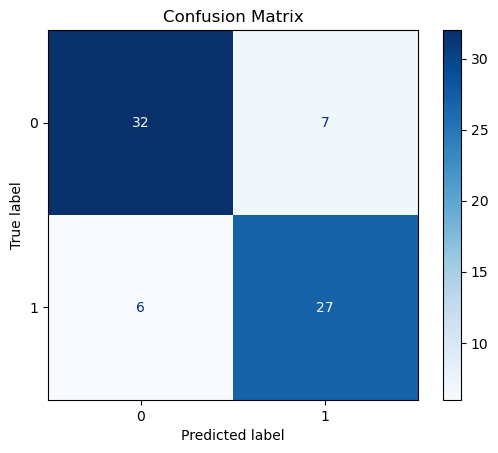

In [41]:
# Define the labels for your classes
class_names = ['0', '1']

# Create the ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

# Plot the confusion matrix
disp.plot(cmap='Blues')

plt.title('Confusion Matrix')
plt.show()

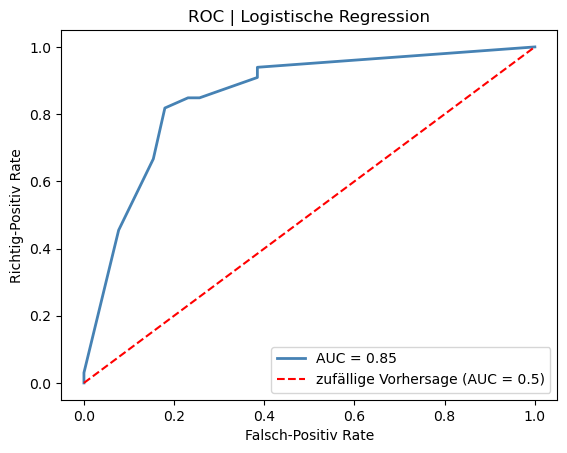

In [42]:
# plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='#4682B4', lw=lw, label='AUC = %0.2f' % roc_auc)
plt.ylabel('Richtig-Positiv Rate') 
plt.plot([0 ,1] ,[0 ,1], 'r', label='zufällige Vorhersage (AUC = 0.5)', linestyle='--') 
plt.xlabel('Falsch-Positiv Rate')
plt.title('ROC | Logistische Regression')
plt.legend(loc="lower right")

plt.show()

<a id="grid"></a>
## Grid Search

In [43]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("best params: ",grid_search.best_params_)
print(grid_search.best_score_)

best params:  {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.837000547345375
